In [1]:
import pandas_datareader as web
import datetime as dt
import pandas as pd
import requests, ast
from bs4 import BeautifulSoup
import dados.html2df as hd
import matplotlib.pyplot as plt

In [2]:
ticket = 'PETR4'

In [3]:
response = requests.get('https://br.advfn.com/common/bov-options/api?symbol={}'.format(ticket))
dic_opt = ast.literal_eval(response.text)
df_opt = pd.DataFrame(dic_opt['result'])

del df_opt['class']
del df_opt['url']
del df_opt['volume_form']
df_opt['strike_price'] = df_opt['strike_price'].apply(lambda x: x.replace(',','.')).astype(float)
df_opt['expiry_date'] = df_opt['expiry_date'].apply(lambda x: x.replace('\\',''))
df_opt['expiry_date'] = pd.to_datetime(df_opt['expiry_date'], format='%d/%m/%Y')
df_opt['volume'] = pd.to_numeric(df_opt['volume'])
df_opt['change_percentage'] = df_opt['change_percentage'].apply(lambda x: x.replace(',','.').replace('%','')).astype(float)/100

def get_historical_opt(dataframe):
    df_dict = {}
    for ticket in dataframe['symbol'].to_numpy():
        df_dict_infos = {}
        df_dict_infos['type'] = dataframe.loc[dataframe['symbol']==ticket]['type'].values[0]
        df_dict_infos['strike'] = dataframe.loc[dataframe['symbol']==ticket]['strike_price'].values[0]
        html_source = requests.get(url='http://br.advfn.com/bolsa-de-valores/bovespa/{}/historico/mais-dados-historicos'.format(ticket))
        html_parser = BeautifulSoup(html_source.text, 'html.parser')
        html_table_historical = html_parser.find_all('table',class_='histo-results')
        df_historical = hd.DfCreator(str(html_table_historical[0]))        
        del df_historical['Variação (%)'] 
        del df_historical['Variação'] 
        df_historical['Data'] = df_historical['Data'].apply(lambda x: x.replace('Fev','Feb').replace('Abr','Apr').replace('Mai','May').replace('Ago','Aug').replace('Set','Sep').replace('Out','Oct').replace('Dez','Dec'))
        df_historical['Data'] = pd.to_datetime(df_historical['Data'], format='%d %b %Y')
        for col in ['Fechamento','Abertura','Máxima','Mínima']:
            df_historical[col] = df_historical[col].apply(lambda x: x.replace(',','.')).astype(float)
        df_historical['Volume'] = df_historical['Volume'].apply(lambda x: x.replace('.','')).astype(float)
        df_dict_infos['dataframe'] = df_historical
        df_dict[ticket] = df_dict_infos
    return df_dict

def plot_graph_opt(opt_dict):
    for ticket in opt_dict:
        x = opt_dict[ticket]['dataframe']['Data'].to_numpy()
        y = opt_dict[ticket]['dataframe']['Volume'].to_numpy()
        fig, axs = plt.subplots(2, figsize=(15,8))
        fig.suptitle('{} - {} - R${}'.format(opt_dict[ticket]['type'],ticket,opt_dict[ticket]['strike']),fontsize=18)
        axs[0].plot(opt_dict[ticket]['dataframe'][['Mínima','Máxima']])
        axs[0].set_ylabel('Max & Min Prices (R$)',fontsize=12)
        axs[0].legend(['Mínima','Máxima'])
        axs[1].bar(x, y, width=0.99, alpha=0.5)
        axs[1].set_ylabel('Volume (10^7)',fontsize=12)
        axs[0].grid(True)
        axs[1].grid(True)
        plt.show()


In [4]:
tickets_selected = df_opt.loc[ df_opt['volume']>df_opt['volume'].mean() ]
tickets_selected

,symbol,type,style,strike_price,expiry_date,volume,change_percentage
0,PETRF306,Call,A,29.96,2021-06-18,38564500.0,-0.1250
1,PETRF296,Call,A,28.96,2021-06-18,23327500.0,0.0714
2,PETRF299,Call,E,29.21,2021-06-18,17549400.0,0.1053
3,PETRF288,Call,A,29.46,2021-06-18,17028800.0,0.2308
4,PETRF294,Call,A,30.46,2021-06-18,14349000.0,0.0000
5,PETRF286,Call,A,28.46,2021-06-18,9209700.0,0.0962
6,PETRF304,Call,A,30.96,2021-06-18,8204700.0,0.0000
7,PETRF283,Call,E,29.71,2021-06-18,6551000.0,0.1111
8,PETRF191,Call,E,20.71,2021-06-18,6028300.0,0.0217
9,PETRR191,Put,E,20.71,2021-06-18,6017200.0,0.0000


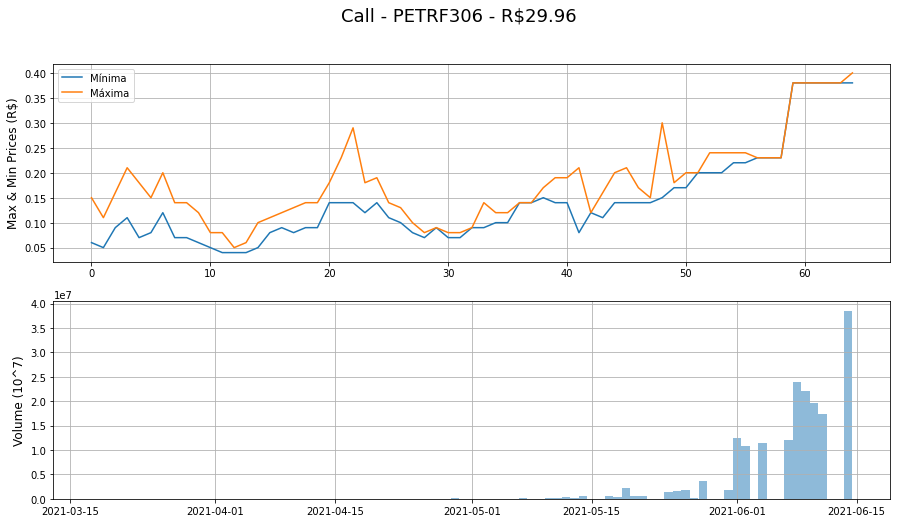

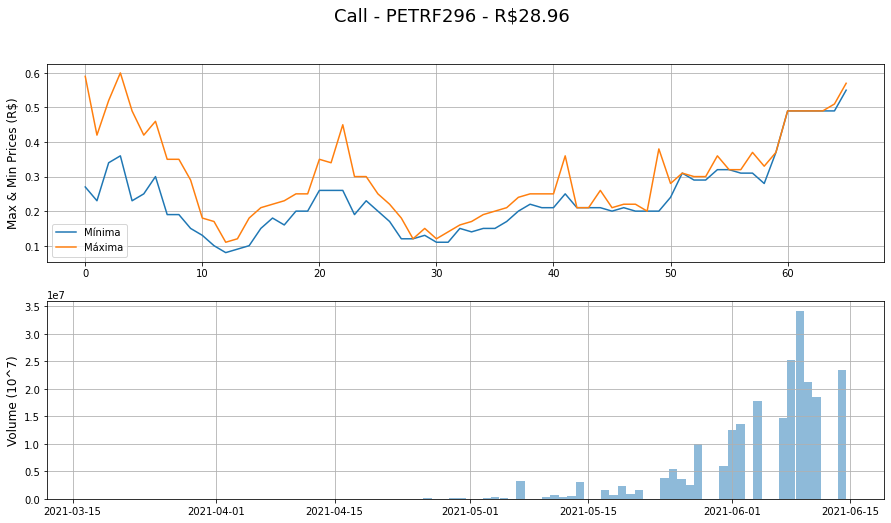

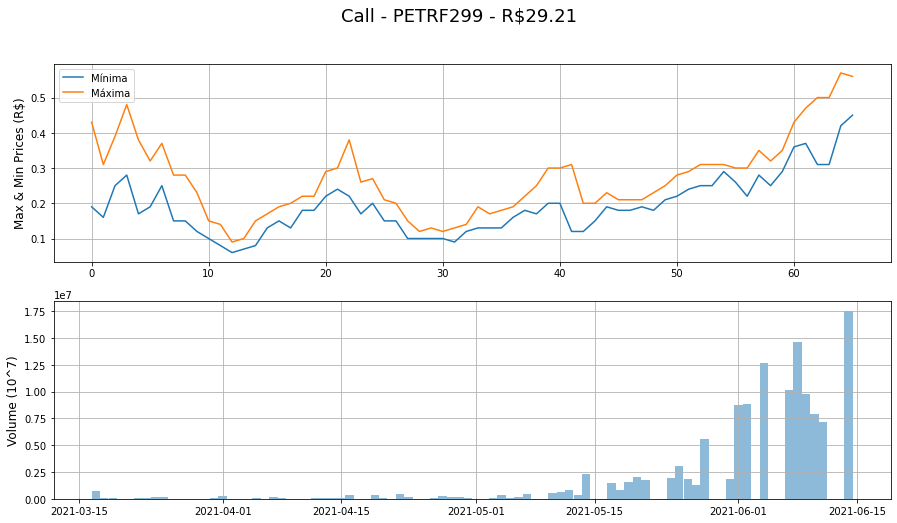

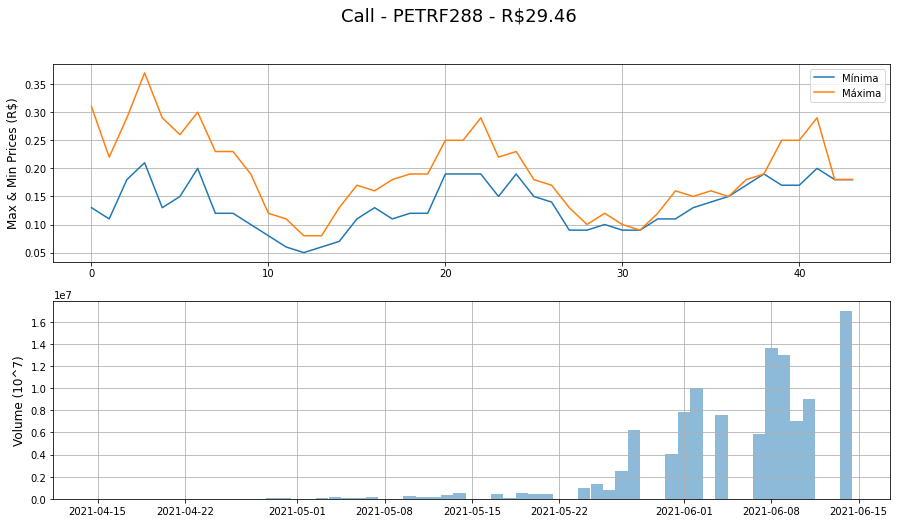

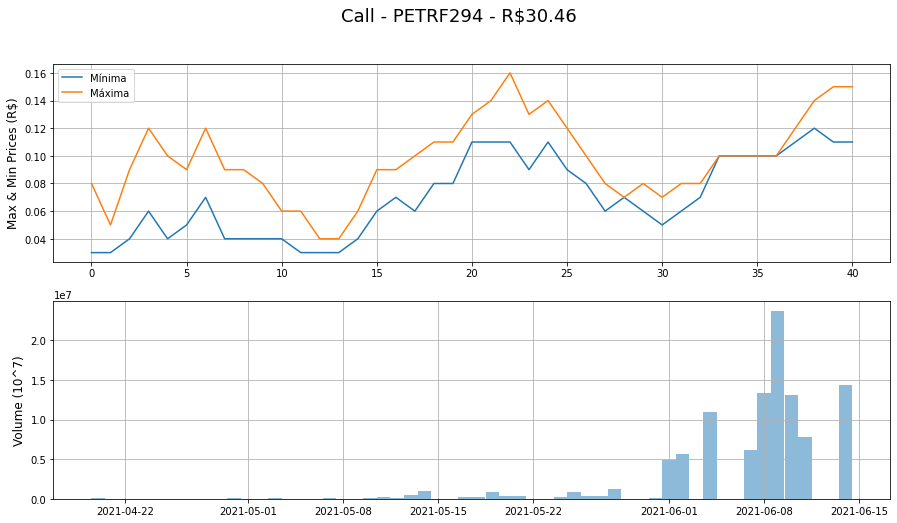

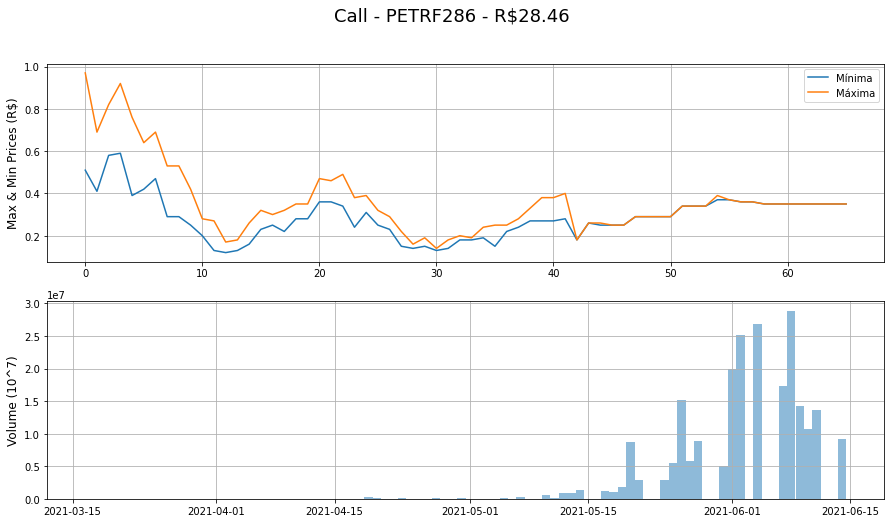

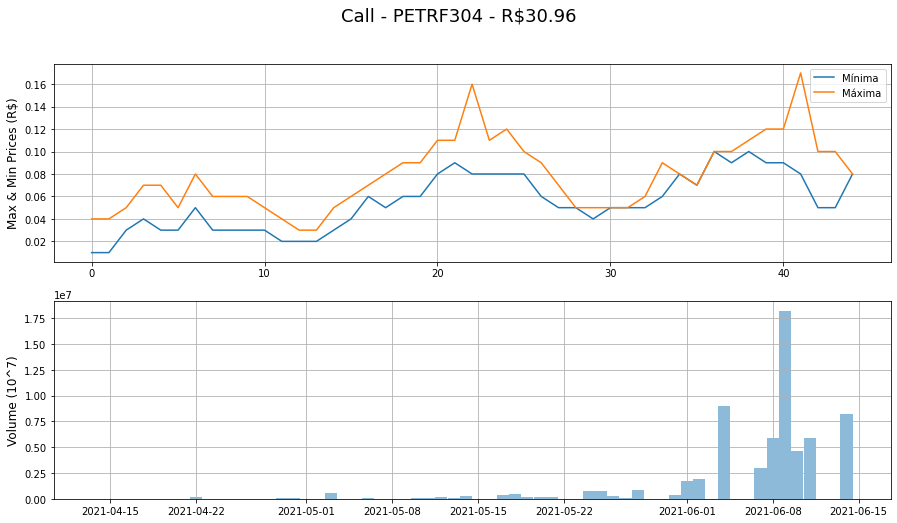

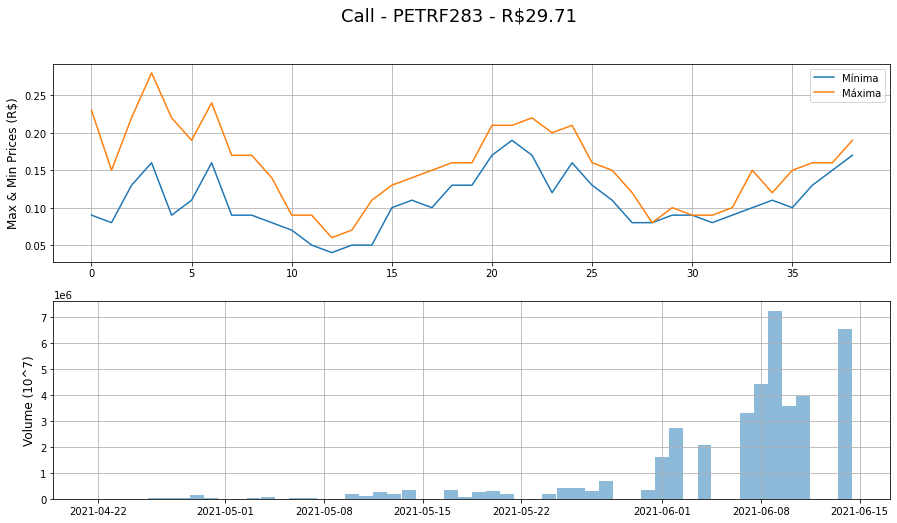

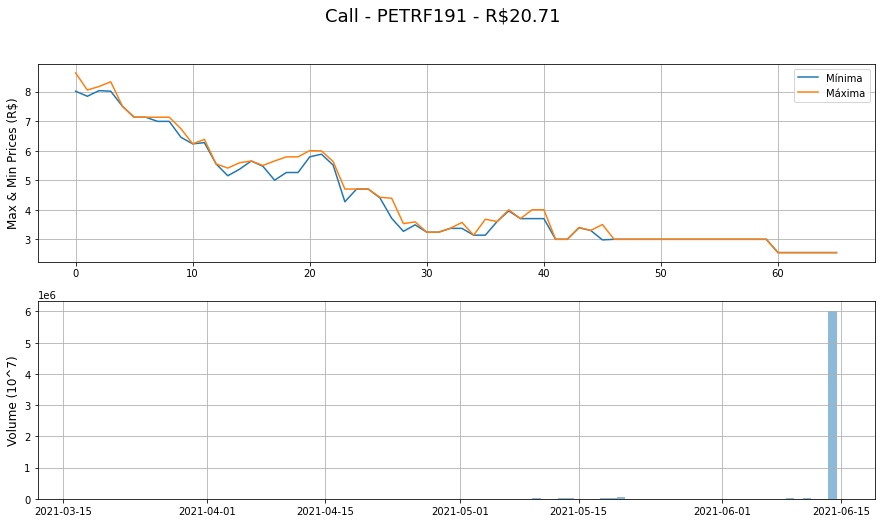

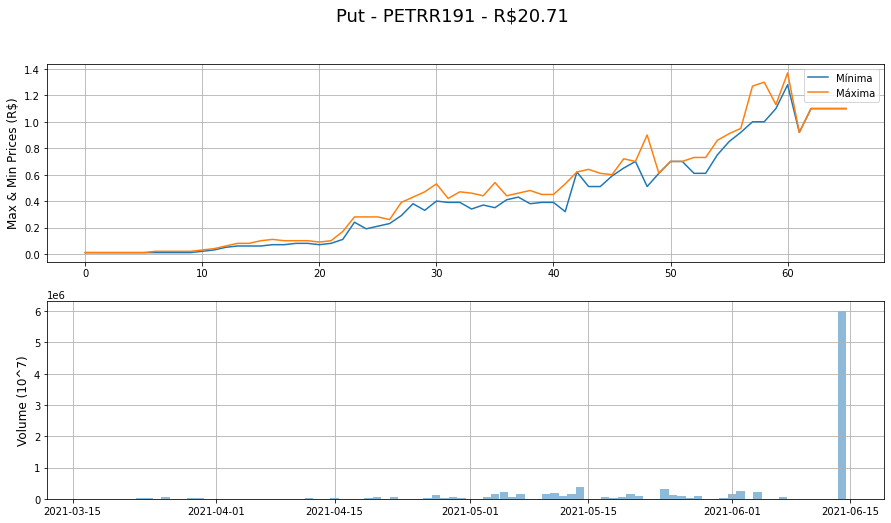

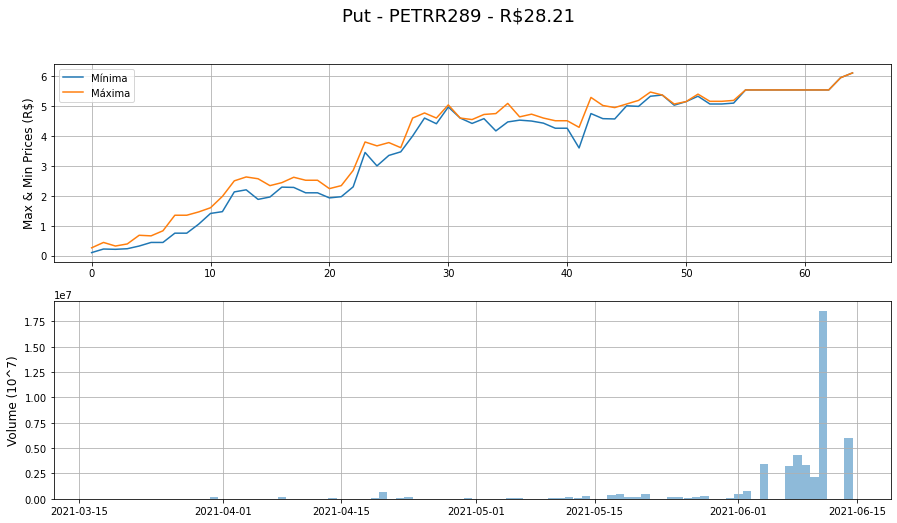

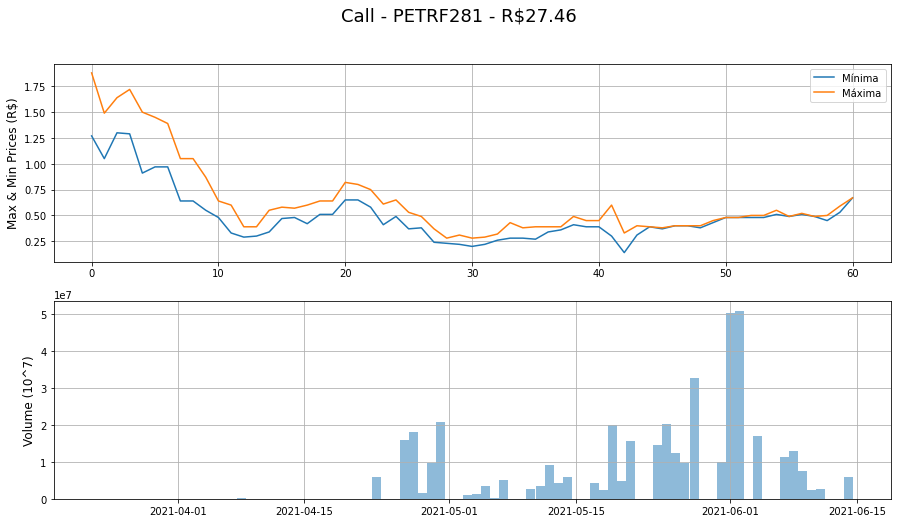

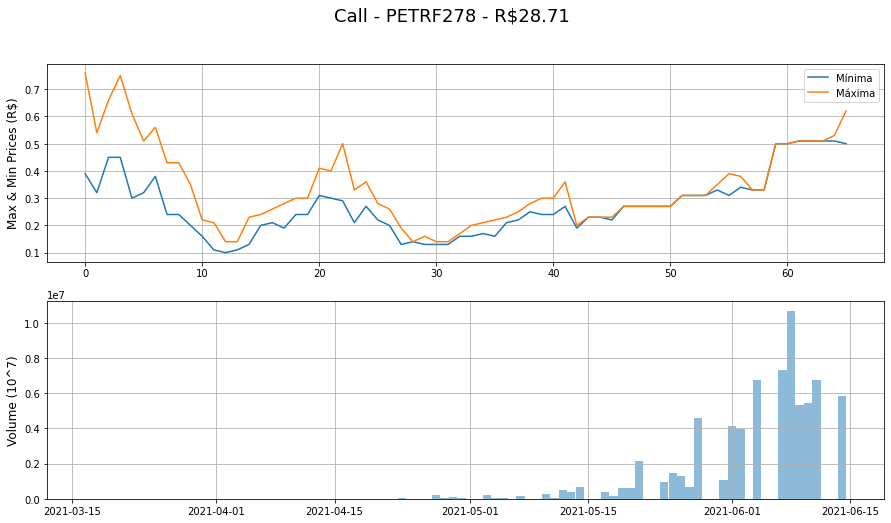

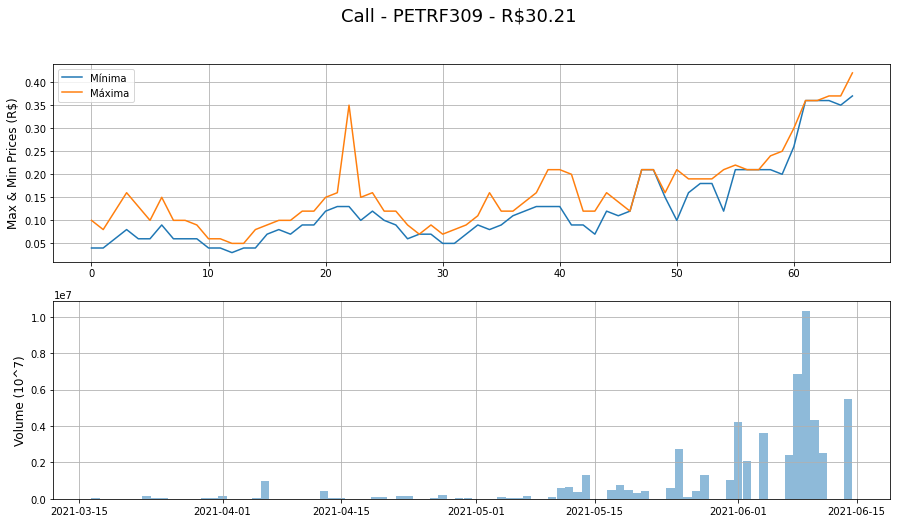

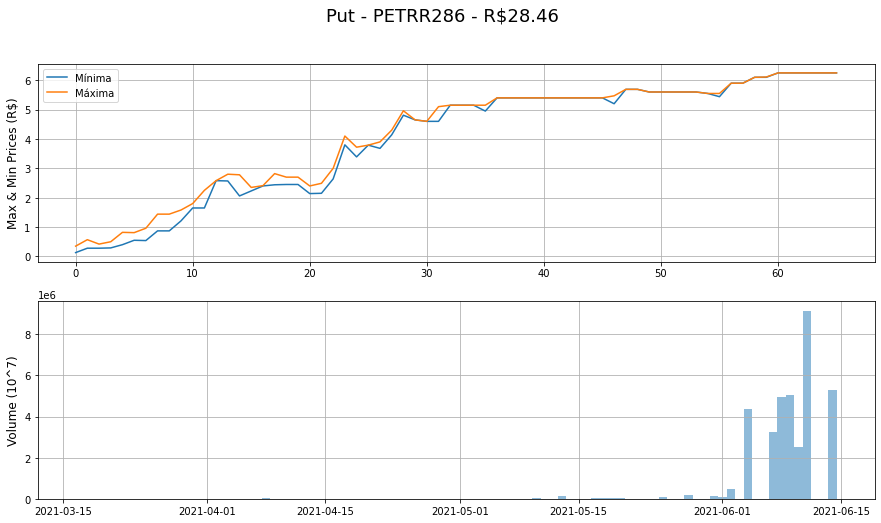

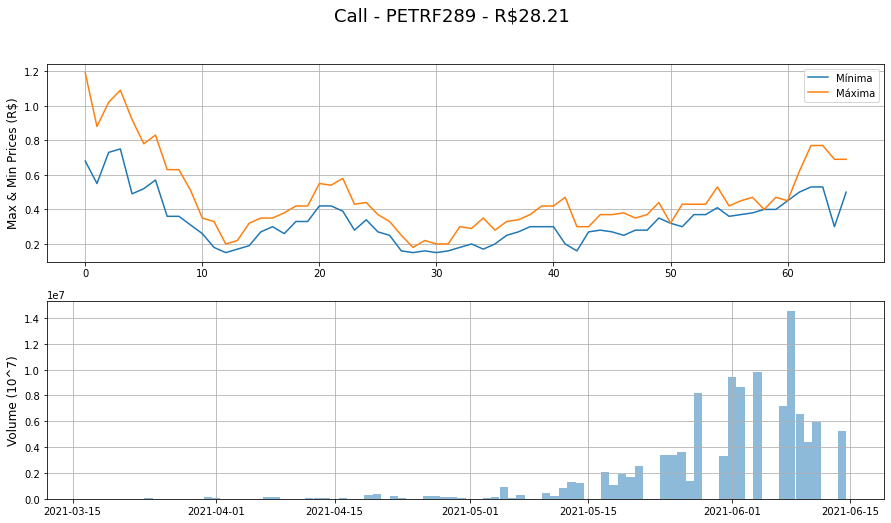

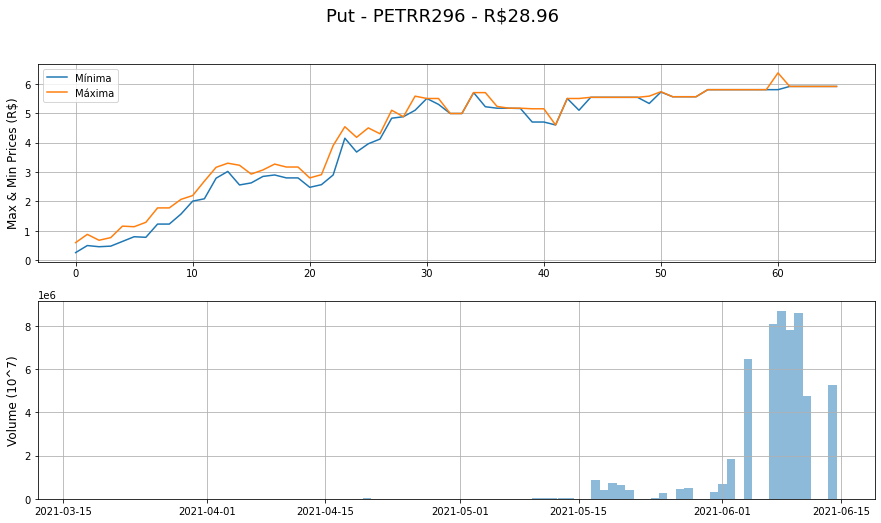

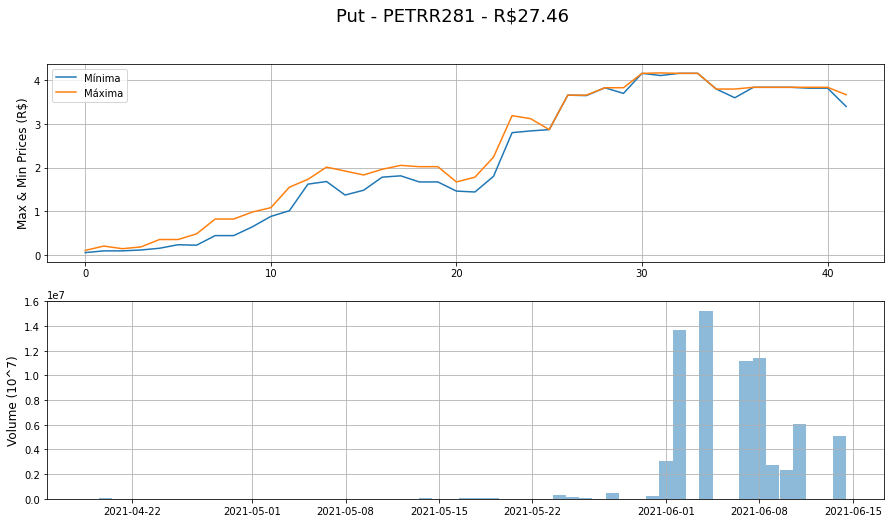

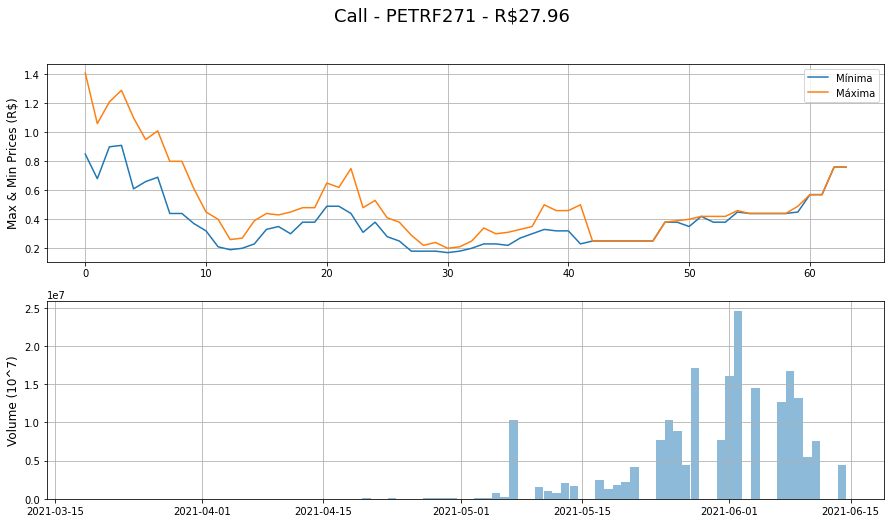

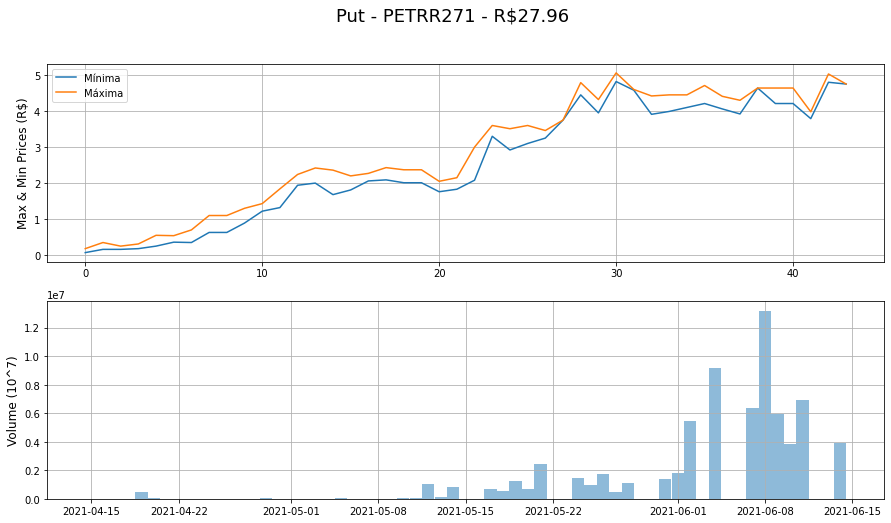

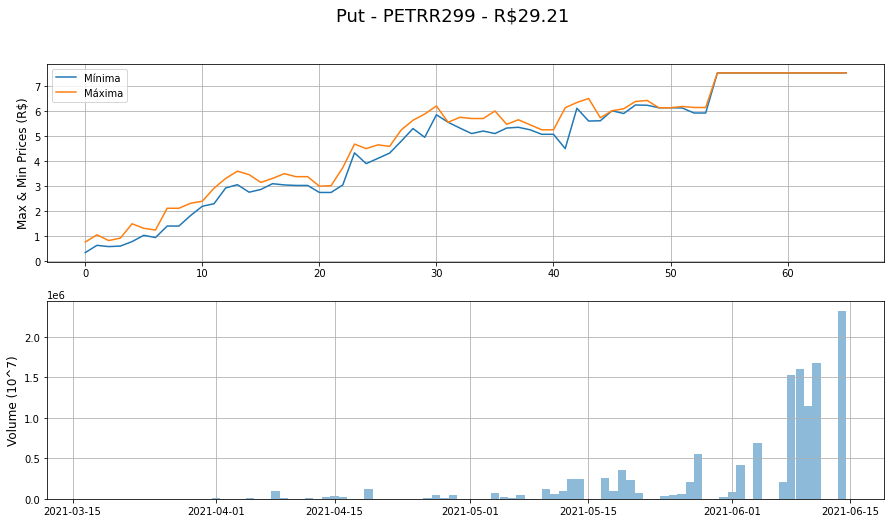

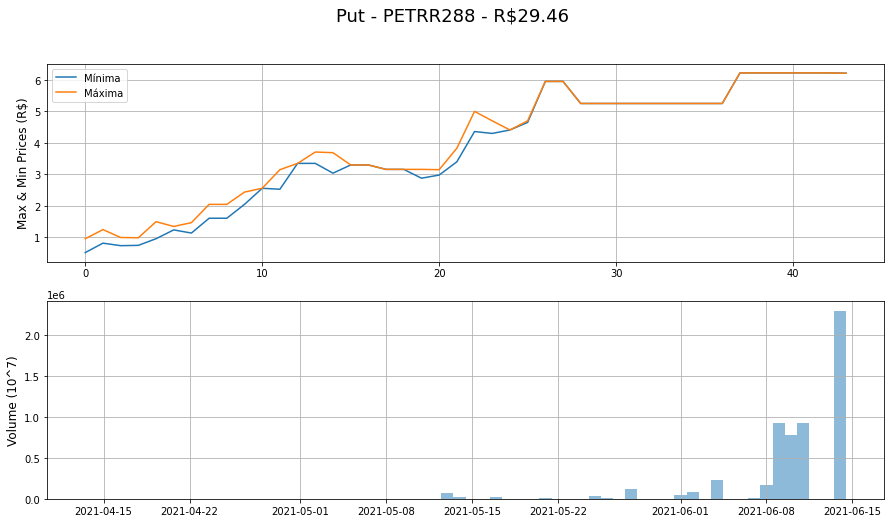

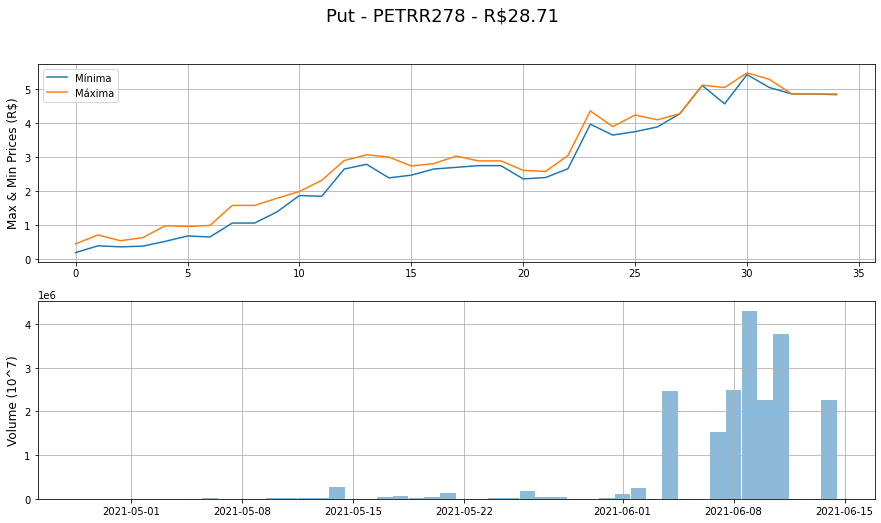

In [5]:
plot_graph_opt(get_historical_opt(tickets_selected))